# Fake News Classifier using RNN, Pre-trained Models and Naive Bayes

# Setting up the Notebook

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/Personal Projects/fake_news_classifier/'

Mounted at /content/drive


In [2]:
!pip install -q tensorflow_addons;
!pip install -q sentencepiece;
!pip install -q tf-models-official;
!pip install -q tensorflow-text;
!pip install -q bert-for-tf2
!pip install -q sentencepiece

     |████████████████████████████████| 706kB 5.4MB/s 
     |████████████████████████████████| 1.2MB 5.6MB/s 
     |████████████████████████████████| 1.1MB 5.2MB/s 
     |████████████████████████████████| 37.6MB 1.3MB/s 
     |████████████████████████████████| 174kB 32.4MB/s 
     |████████████████████████████████| 358kB 41.4MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 645kB 45.0MB/s 
     |████████████████████████████████| 3.4MB 4.1MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 


In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib sizes and settings
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

# TensorFlow libraries
%tensorflow_version 2.x 
import numpy as np
import tensorflow_addons as tfa
import tensorflow as tf
import tensorflow_hub as hub
import keras
import bert
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Base libraries
import matplotlib.pyplot as plt
random_seed = 81
import numpy as np
import pandas as pd
from os import listdir
import string
from tqdm import tqdm
import pickle
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

# Gensim
import gensim

tf.random.set_seed(random_seed)
np.random.seed(random_seed)

## Helper Functions

In [4]:
def print_scores(label, pred):
  print(f'Accuracy_score: {accuracy_score(label, pred):.2f}', 
        f'f1_score: {f1_score(label, pred):.2f}', 
        f'recall_score: {recall_score(label, pred):.2f}', 
        f'precision_score: {precision_score(label, pred):.2f}', sep='\n', end='\n\n')

# Loading Data

link to data: https://www.kaggle.com/c/fake-news/leaderboard

In [38]:
df_test[df_test['text'].apply(lambda x: not isinstance(x, str))]

,id,title,author,text
589,21389,[Vidéo] Que trouve-t-on dans « Le Gorafi de l’...,NaN,NaN
626,21426,Nous avons comparé les programmes d’Alain Jupp...,NaN,NaN
978,21778,« J’y crois encore ! » par Alain Juppé en trai...,NaN,NaN
2257,23057,Horoscope du 14 novembre 2016 >> Le Gorafi,NaN,NaN
2892,23692,Une fan demande le remboursement de son tatoua...,NaN,NaN
4736,25536,Révélations – François Fillon serait de droite...,NaN,NaN
5092,25892,Des traces de vin rouge détectées dans le Beau...,NaN,NaN


In [8]:
df_test = pd.read_csv(abspath_curr+'data/test.csv')
y_sub = pd.read_csv(abspath_curr+'data/submit.csv')
y_sub.drop('label', axis=1, inplace=True)
# df_test = df_test[df_test['text'].apply(lambda x: isinstance(x, str))]
print(len(df_test))

5200


In [10]:
df_train = pd.read_csv(abspath_curr+'data/train.csv')
df_train = df_train[['text', 'label']]
# df_train = df_train[df_train['text'].apply(lambda x: isinstance(x, str))]
print(df_train.shape)
df_train.head()

(20800, 2)


,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
print(df_train.shape)
print(df_train.dtypes)

(20800, 2)
text     object
label     int64
dtype: object


In [12]:
df_train['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

# Pre-processing Data (Tokenizaton and Word Embeddings)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(df_train[['text']], df_train[['label']], test_size=0.2, shuffle=True, random_state=81)

## Apply GloVe Embeddings to Tokenized Text

In [16]:
def tokenizer_spacy(df, col, filename):
  # initialize list to be populated with the tokenized answers
  train_tokenized = []
  # Convert answers to a list
  train_list = df[col].values.tolist()
  # Loop through each answer
  for answer in tqdm(train_list):
      # empty string to populate with the chosen tokens
      tokens_joined = ''
      # spacy object pepares sentence to be parsed
      try:
        nlpd = nlp(answer)
        # for each word in answer
        for t in nlpd:
            # check that it is alphabetic, not a stopword, not punctuation and not a space
            if (t.is_alpha) and (not t.is_stop) and (not t.is_punct) and (not t.is_space):
                # if all conditions above are met, covert token back to string, normalize word to its Lemma, lower letter cases and add to empty string with a space behind it to keep words seperate
                tokens_joined += ' '+t.lemma_.lower()
        # append resulting string to the train_tokenized list
        train_tokenized.append(tokens_joined.strip())
      except:
        train_tokenized.append('Not processable')
  # save resulting file in pickle format
  pickle.dump(train_tokenized, open(abspath_curr+'data/'+filename+'.pkl', 'wb'))
  return train_tokenized

In [17]:
tokenize = True
if tokenize == True:
  X_train_tok = tokenizer_spacy(X_train, 'text', 'X_train_tok')
  X_val_tok = tokenizer_spacy(X_val, 'text', 'X_val_tok')
  X_test_tok = tokenizer_spacy(df_test, 'text', 'X_test_tok')
else:
  X_train_tok =pickle.load(open(abspath_curr+'data/X_train_tok.pkl', 'rb'))
  X_val_tok =pickle.load(open(abspath_curr+'data/X_val_tok.pkl', 'rb'))
  X_test_tok =pickle.load(open(abspath_curr+'data/X_test_tok.pkl', 'rb'))

100%|██████████| 5200/5200 [10:58<00:00,  7.90it/s]


Largest 10 lengths: [135621, 62402, 58951, 52979, 52858, 52435, 47963, 39635, 38018, 36700]
median of lengths: 2004.5
mean of lengths: 2693.5127403846154


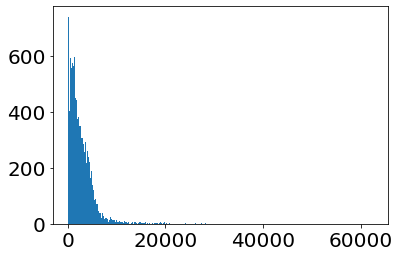

In [18]:
lens = [len(x) for x in X_train_tok]
lens = sorted(lens, reverse=True)
max_len = max(lens)
print('Largest 10 lengths:', lens[0:10])
print('median of lengths:', np.median(lens))
print('mean of lengths:', np.mean(lens))
plt.hist(lens[1:], bins=500)
plt.show()

In [19]:
max_len = 2000

In [20]:
# oov_token='<UNK>'
tok = tf.keras.preprocessing.text.Tokenizer()
tok.fit_on_texts(X_train_tok)
word_index = tok.word_index

train_seq = tok.texts_to_sequences(X_train_tok)
val_seq = tok.texts_to_sequences(X_val_tok)
test_seq =tok.texts_to_sequences(X_test_tok)

X_train_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=max_len)
X_val_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(val_seq, maxlen=max_len)
X_test_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len)

In [21]:
word_emb_w2v = {}
file_emb = open(abspath_curr+"data/glove.6B.300d.txt", encoding="utf-8")
for emb in tqdm(file_emb):
  array = emb.split()
  word = str(array[0])
  vector = np.asarray(array[1:], dtype=np.float32)
  word_emb_w2v[word] = vector
file_emb.close()

400000it [00:34, 11701.52it/s]


In [22]:
num_o_words = len(word_index)+1
print(num_o_words)
emb_dim = 300 # size of w2v vector
emb_mtrx = np.zeros((num_o_words, emb_dim))

for word, i in word_index.items():
  if i > num_o_words:
    continue
  emb_vector = word_emb_w2v.get(word)
  if emb_vector is not None:
    emb_mtrx[i] = emb_vector

138531


# Models

## Bi-directional RNN with LSTM cell

In [23]:
model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=num_o_words, output_dim=emb_dim, input_length=max_len, 
                              embeddings_initializer = tf.keras.initializers.Constant(emb_mtrx), trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
print(model_rnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 300)         41559300  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 41,754,501
Trainable params: 195,201
Non-trainable params: 41,559,300
_________________________________________________________________
None


In [24]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + 'model/model_rnn.h5', save_best_only=True,
                                                      save_weights_only=True)
# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

In [25]:
model_rnn.compile(tf.keras.optimizers.Adam(learning_rate=0.0001) , loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                metrics=['accuracy'])

In [26]:
history = model_rnn.fit(X_train_tok_padded, y_train.values, validation_data=(X_val_tok_padded, y_val.values), batch_size= 32, epochs=8,
                    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/8
520/520 [==============================] - 121s 198ms/step - loss: 0.6198 - accuracy: 0.5582 - val_loss: 0.3937 - val_accuracy: 0.8262
Epoch 2/8
520/520 [==============================] - 104s 200ms/step - loss: 0.3882 - accuracy: 0.8265 - val_loss: 0.3553 - val_accuracy: 0.8332
Epoch 3/8
520/520 [==============================] - 104s 200ms/step - loss: 0.3433 - accuracy: 0.8522 - val_loss: 0.3094 - val_accuracy: 0.8757
Epoch 4/8
520/520 [==============================] - 104s 200ms/step - loss: 0.2883 - accuracy: 0.8811 - val_loss: 0.2862 - val_accuracy: 0.8863
Epoch 5/8
520/520 [==============================] - 104s 200ms/step - loss: 0.2652 - accuracy: 0.8914 - val_loss: 0.2611 - val_accuracy: 0.8950
Epoch 6/8
520/520 [==============================] - 104s 200ms/step - loss: 0.2428 - accuracy: 0.9005 - val_loss: 0.2575 - val_accuracy: 0.8990
Epoch 7/8
520/520 [==============================] - 104s 200ms/step - loss: 0.2278 - accuracy: 0.9082 - val_loss: 0.3108 - val_ac

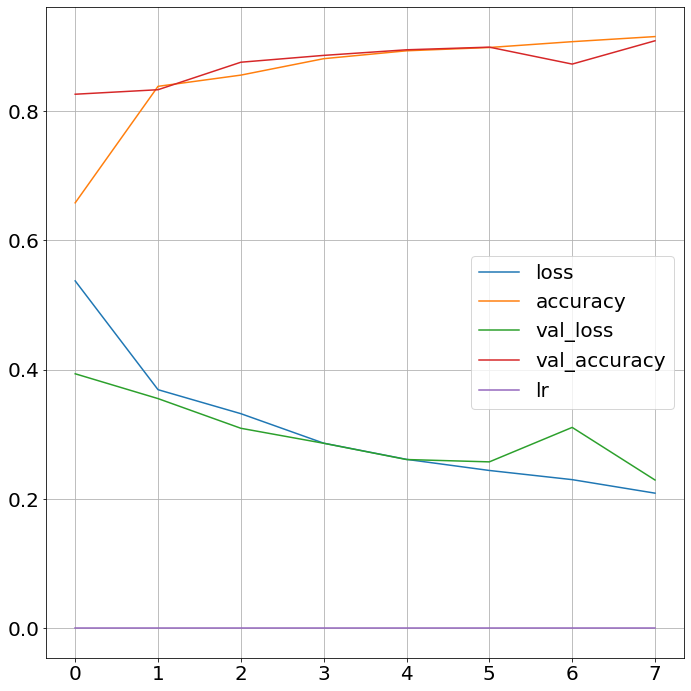

In [75]:
# Create a figure
plot_hist = pd.DataFrame(history.history)
plot_hist.plot(figsize=(10, 10))
plot_hist.to_csv(abspath_curr+'/plots/history.csv')
# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.legend(loc='best')
plt.savefig(abspath_curr+'plots/history.png')
plt.show()

In [28]:
model_rnn.load_weights(abspath_curr + 'model/model_rnn.h5')
preds_rnn = model_rnn.predict_classes(X_test_tok_padded)

In [39]:
pd.concat([y_sub,  pd.DataFrame({'label':preds_rnn.flatten()}, index=y_sub.index.values)], 
          axis=1).to_csv(abspath_curr+'submission/preds_rnn.csv', index=False)

## CNN and RNN with LSTM cell

In [63]:
model_crnn = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=num_o_words, output_dim=emb_dim, input_length=max_len, 
                              embeddings_initializer = tf.keras.initializers.Constant(emb_mtrx), trainable=False),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
print(model_crnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 300)         41559300  
_________________________________________________________________
conv1d (Conv1D)              (None, 2000, 128)         115328    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 41,728,261
Trainable params: 168,961
Non-trainable params: 41,559,300
____________________________________

In [64]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + 'model/model_crnn.h5', save_best_only=True,
                                                      save_weights_only=True)

In [65]:
model_crnn.compile(tf.keras.optimizers.Adam(learning_rate=0.0001) , loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                metrics=['accuracy'])

In [66]:
history_crnn = model_crnn.fit(X_train_tok_padded, y_train.values, validation_data=(X_val_tok_padded, y_val.values), batch_size= 32, epochs=8,
                    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/8
520/520 [==============================] - 42s 77ms/step - loss: 0.5630 - accuracy: 0.6315 - val_loss: 0.2924 - val_accuracy: 0.8748
Epoch 2/8
520/520 [==============================] - 39s 76ms/step - loss: 0.2812 - accuracy: 0.8794 - val_loss: 0.2647 - val_accuracy: 0.8769
Epoch 3/8
520/520 [==============================] - 39s 76ms/step - loss: 0.2198 - accuracy: 0.9118 - val_loss: 0.2150 - val_accuracy: 0.9151
Epoch 4/8
520/520 [==============================] - 39s 76ms/step - loss: 0.1920 - accuracy: 0.9226 - val_loss: 0.1996 - val_accuracy: 0.9248
Epoch 5/8
520/520 [==============================] - 40s 76ms/step - loss: 0.1638 - accuracy: 0.9351 - val_loss: 0.2032 - val_accuracy: 0.9118
Epoch 6/8
520/520 [==============================] - 40s 77ms/step - loss: 0.1310 - accuracy: 0.9486 - val_loss: 0.1985 - val_accuracy: 0.9274
Epoch 7/8
520/520 [==============================] - 40s 77ms/step - loss: 0.1095 - accuracy: 0.9578 - val_loss: 0.1898 - val_accuracy: 0.9274

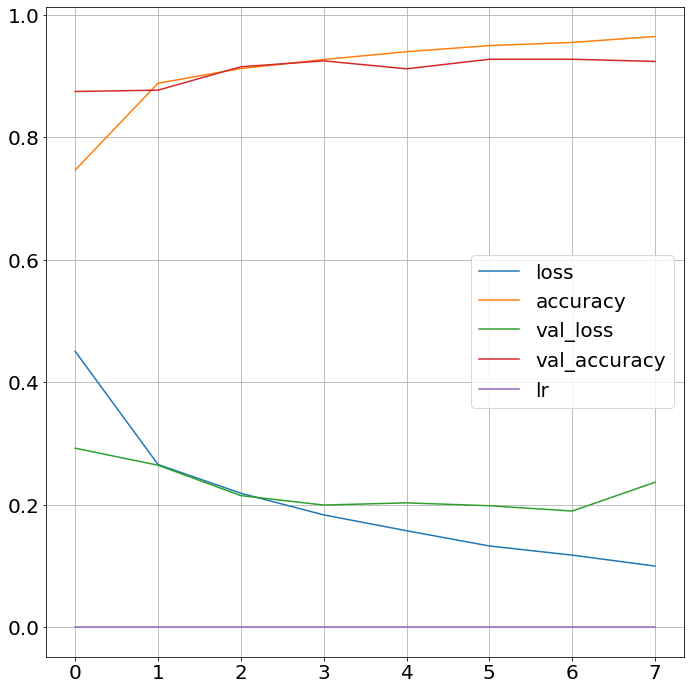

In [74]:
# Create a figure
plot_hist = pd.DataFrame(history_crnn.history)
plot_hist.plot(figsize=(10, 10))
plot_hist.to_csv(abspath_curr+'/plots/history_crnn.csv')
# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.legend(loc='best')
plt.savefig(abspath_curr+'plots/history_crnn.png')
plt.show()

In [70]:
model_crnn.load_weights(abspath_curr + 'model/model_crnn.h5')
pred_crnn=model_crnn.predict_classes(X_test_tok_padded)

In [72]:
pd.concat([y_sub,  pd.DataFrame({'label':pred_crnn.flatten()}, index=y_sub.index.values)], 
          axis=1).to_csv(abspath_curr+'submission/pred_crnn.csv', index=False)

## Pre-trained NNLM 128 Model

In [41]:
# QNA only unbatched
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train_tok, y_train.values.flatten())).batch(batch_size).prefetch(AUTOTUNE)
val_dataset_tf = tf.data.Dataset.from_tensor_slices((X_val_tok,y_val.values.flatten())).batch(batch_size).prefetch(AUTOTUNE)
test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test_tok)).batch(batch_size).prefetch(AUTOTUNE)

In [42]:
# Get the model
import tensorflow_hub as hub
model_nnlm128 = keras.Sequential([hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1',
                                         trainable=False,
                                         dtype=tf.string,
                                         input_shape=[],
                                         output_shape=[128]),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dropout(0.1),
                          keras.layers.Dense(1, activation='sigmoid')])

# Get the model summary
model_nnlm128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 124,659,329
Trainable params: 16,641
Non-trainable params: 124,642,688
_________________________________________________________________


In [43]:
# ModelCheckpoint callback
model_checkpoint_cb2 = keras.callbacks.ModelCheckpoint(filepath=abspath_curr+'/model/model_nnlm128.h5',
                                                      save_best_only=True, save_weights_only=True)
# EarlyStopping callback
early_stopping_cb2 = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb2 = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
# Compile the model
model_nnlm128.compile(optimizer=keras.optimizers.Adam(learning_rate=10 ** -3),
              loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
# Train, evaluate and save the best model
history2a = model_nnlm128.fit(x = train_dataset_tf ,epochs=3, validation_data=val_dataset_tf,
                            callbacks=[model_checkpoint_cb2, early_stopping_cb2, reduce_lr_on_plateau_cb2])

Epoch 1/3
520/520 [==============================] - 5s 8ms/step - loss: 0.5246 - accuracy: 0.7266 - val_loss: 0.3732 - val_accuracy: 0.8425
Epoch 2/3
520/520 [==============================] - 4s 7ms/step - loss: 0.3723 - accuracy: 0.8388 - val_loss: 0.3472 - val_accuracy: 0.8502
Epoch 3/3
520/520 [==============================] - 4s 8ms/step - loss: 0.3439 - accuracy: 0.8525 - val_loss: 0.3321 - val_accuracy: 0.8570


In [45]:
# Unfreeze the pretrained layers
model_nnlm128.layers[0].trainable = True
# Compile the model
model_nnlm128.compile(optimizer=keras.optimizers.Adam(learning_rate=10 ** -4), loss='binary_crossentropy',
                      metrics=['accuracy'])
# Get the model summary
model_nnlm128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 124,659,329
Trainable params: 124,659,329
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Train, evaluate and save the best model
history2b = model_nnlm128.fit(x = train_dataset_tf ,epochs=3, validation_data=val_dataset_tf,
                            callbacks=[model_checkpoint_cb2, early_stopping_cb2, reduce_lr_on_plateau_cb2])

Epoch 1/3
520/520 [==============================] - 20s 38ms/step - loss: 0.2782 - accuracy: 0.8849 - val_loss: 0.2095 - val_accuracy: 0.9209
Epoch 2/3
520/520 [==============================] - 19s 37ms/step - loss: 0.1544 - accuracy: 0.9459 - val_loss: 0.1673 - val_accuracy: 0.9373
Epoch 3/3
520/520 [==============================] - 19s 37ms/step - loss: 0.0938 - accuracy: 0.9715 - val_loss: 0.1474 - val_accuracy: 0.9445


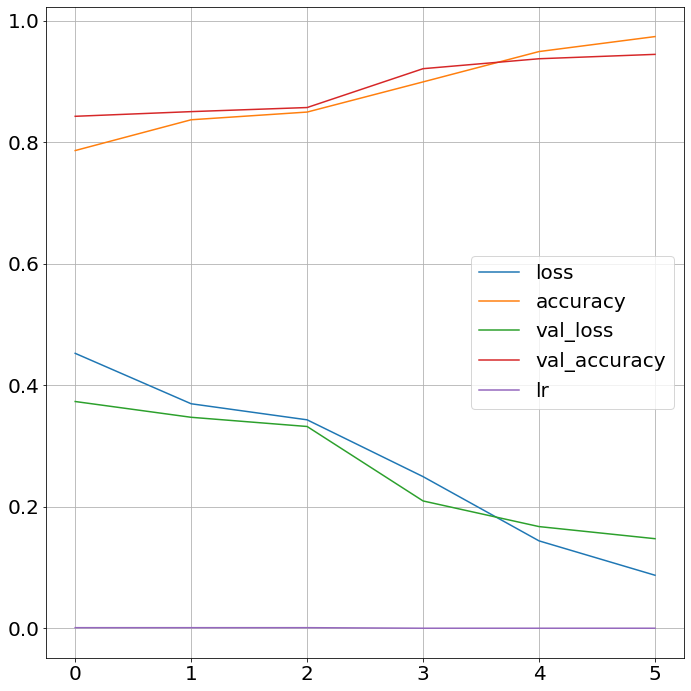

In [73]:
# Create a figure
plot_hist = pd.concat([pd.DataFrame(history2a.history), pd.DataFrame(history2b.history)], axis=0).reset_index(drop=True)
plot_hist.plot(figsize=(10, 10))
plot_hist.to_csv(abspath_curr+'/plots/history2.csv')
# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.legend(loc='best')
plt.savefig(abspath_curr+'plots/history2.png')
plt.show()

In [48]:
model_nnlm128.load_weights(abspath_curr + 'model/model_nnlm128.h5')
pred_nnlm128=model_nnlm128.predict_classes(test_dataset_tf)

In [49]:
pd.concat([y_sub,  pd.DataFrame({'label':pred_nnlm128.flatten()}, index=y_sub.index.values)], 
          axis=1).to_csv(abspath_curr+'submission/pred_nnlm128.csv', index=False)

## Naive Bayes

In [50]:
X_train_val = pd.concat([pd.DataFrame({'text':X_train_tok}), pd.DataFrame({'text':X_val_tok})], axis=0)
y_train_val = np.vstack((y_train['label'].values.reshape(-1,1), y_val['label'].values.reshape(-1,1)))
len_train=np.append(np.full(X_train.shape[0], -1), np.full(X_val.shape[0], 0))
ps = PredefinedSplit(len_train)

In [51]:
vectorizers = {'counter': CountVectorizer(),
                'tfidf': TfidfVectorizer()}
pipes = {}

for acronym, vec in vectorizers.items():
    pipes[acronym] = Pipeline(steps=[('vec', vec), ('mnb', MultinomialNB(alpha=1))])

# param grid for CountVectorizer and TfIdf
ngram_range = [(1, 1), (2, 2)]
max_df=[0.8, 0.9, 1.0]
min_df=[1, 0.01, 0.02]
max_features= [5500, 10500, 50500, 100500, 150500, None]

param_grids = {}
# Update param_grids
param_grids['counter'] = [{'vec__ngram_range': ngram_range,
                           'vec__max_df': max_df,
                           'vec__min_df': min_df,
                           'vec__max_features': max_features}]

param_grids['tfidf'] = [{'vec__ngram_range': ngram_range,
                           'vec__max_df': max_df,
                           'vec__min_df': min_df,
                           'vec__max_features': max_features}]

In [52]:
best_score_params_estimator_gs = []

for acronym in pipes.keys():
  gs = GridSearchCV(estimator=pipes[acronym],
                    param_grid=param_grids[acronym],
                    scoring='accuracy',
                    n_jobs=2,
                    cv = ps,
                    refit=True,
                    return_train_score=True,
                    verbose=1)
  gs = gs.fit(X_train_val['text'].values, y_train_val)
  best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
  
  cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
  important_columns = ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'mean_fit_time',
                      'std_fit_time', 'mean_score_time', 'std_score_time']

  cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

  cv_results.to_csv(path_or_buf=abspath_curr + 'GridSearchCV/' + acronym + '.csv', index=False)
pickle.dump(best_score_params_estimator_gs, open(abspath_curr+'/model/mnb.pkl', 'wb'))
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)
gs_table = pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

Fitting 1 folds for each of 108 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed: 21.3min finished


Fitting 1 folds for each of 108 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed: 21.5min finished


In [53]:
best_score_params_estimator_gs = pickle.load(open(abspath_curr+'model/mnb.pkl', 'rb'))

In [59]:
x_test_transformed = best_score_params_estimator_gs[0][2][0].transform(X_test_tok)
y_pred_mnb = best_score_params_estimator_gs[0][2][1].predict(x_test_transformed)

In [61]:
pd.concat([y_sub,  pd.DataFrame({'label':y_pred_mnb}, index=y_sub.index.values)], 
          axis=1).to_csv(abspath_curr+'submission/pred_mnb.csv', index=False)